# Multilingual Hate Speech Detection Training

This notebook trains baseline ML models and transformer models for multilingual hate speech detection, then exports them for API and mobile deployment.


## 1. Setup and Dependencies


In [ ]:
# Install required packages
%pip install transformers datasets accelerate scikit-learn onnx onnxruntime torch matplotlib seaborn pandas numpy
%pip install --upgrade huggingface_hub


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 76.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 119.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 563.4/563.4 kB 10.9 MB/s eta 0:00:00
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.34.4
    Uninstalling huggingface-hub-0.34.4:
      Successfully uninstalled huggingface-hub-0.34.4


In [ ]:
import os
import json
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, EarlyStoppingCallback
)
from datasets import load_dataset, Dataset as HFDataset
import onnx
from onnxruntime import InferenceSession
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")


PyTorch version: 2.8.0+cu126
CUDA available: True
CUDA device: NVIDIA A100-SXM4-40GB


## 2. Data Loading and Preprocessing


In [ ]:
# Load the multilingual hate speech dataset focusing on Arabic, Turkish, and English
print("Loading multilingual dataset for Arabic, Turkish, and English...")

# Load the main training dataset
train_dataset = load_dataset("FrancophonIA/multilingual-hatespeech-dataset", "Multilingual_train")
print(f"Training dataset loaded: {len(train_dataset['train'])} samples")

# Load specific language test datasets
target_languages = ['Arabic_test', 'Turkish_test', 'English_test']
test_datasets = {}

print("\nLoading target language test datasets...")
for lang in target_languages:
    try:
        test_datasets[lang] = load_dataset("FrancophonIA/multilingual-hatespeech-dataset", lang)
        print(f"✓ {lang}: {len(test_datasets[lang]['test'])} samples")
    except Exception as e:
        print(f"✗ {lang}: Failed to load - {e}")

# Explore the main training dataset structure
print(f"\nTraining dataset features:")
print(f"Features: {train_dataset['train'].features}")
print(f"Sample: {train_dataset['train'][0]}")
print(f"Total training samples: {len(train_dataset['train'])}")

# Debug: Check the first few samples to understand the structure
print(f"\nFirst 3 samples for debugging:")
for i in range(min(3, len(train_dataset['train']))):
    sample = train_dataset['train'][i]
    print(f"Sample {i}: {sample}")
    print(f"Keys: {list(sample.keys())}")
    print("---")


Loading multilingual dataset for Arabic, Turkish, and English...


README.md: 0.00B [00:00, ?B/s]

MultiLanguageTrainDataset.csv:   0%|          | 0.00/36.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/219981 [00:00<?, ? examples/s]

Training dataset loaded: 219981 samples

Loading target language test datasets...


Arabic_test.csv: 0.00B [00:00, ?B/s]

Generating test split:   0%|          | 0/463 [00:00<?, ? examples/s]

✓ Arabic_test: 463 samples


Turkish_test.csv: 0.00B [00:00, ?B/s]

Generating test split:   0%|          | 0/5397 [00:00<?, ? examples/s]

✓ Turkish_test: 5397 samples


English_test.csv: 0.00B [00:00, ?B/s]

Generating test split:   0%|          | 0/5906 [00:00<?, ? examples/s]

✓ English_test: 5906 samples

Training dataset features:
Features: {'Unnamed: 0': Value('int64'), 'text': Value('string'), 'label': Value('float64'), 'language': Value('int64')}
Sample: {'Unnamed: 0': 0, 'text': 'لك من جهة ان شاء بضل حرقة بقلبك وبلاطه ع صدرك و غصة بزلاعيمك الشيخ سعد و من جهة تانيه بضل جالطك اللواء عثمان', 'label': 0.0, 'language': 1}
Total training samples: 219981

First 3 samples for debugging:
Sample 0: {'Unnamed: 0': 0, 'text': 'لك من جهة ان شاء بضل حرقة بقلبك وبلاطه ع صدرك و غصة بزلاعيمك الشيخ سعد و من جهة تانيه بضل جالطك اللواء عثمان', 'label': 0.0, 'language': 1}
Keys: ['Unnamed: 0', 'text', 'label', 'language']
---
Sample 1: {'Unnamed: 0': 1, 'text': 'انجاز جديد للعهدجبران باسيل', 'label': 0.0, 'language': 1}
Keys: ['Unnamed: 0', 'text', 'label', 'language']
---
Sample 2: {'Unnamed: 0': 2, 'text': 'قلبه كبير وئام وديموقراطي عكس باسيل هههه ', 'label': 0.0, 'language': 1}
Keys: ['Unnamed: 0', 'text', 'label', 'language']
---


In [ ]:
def preprocess_multilingual_text(text):
    """Enhanced preprocessing for Arabic, Turkish, and English text"""
    if text is None:
        return ""

    # Convert to string and strip whitespace
    text = str(text).strip()

    # Remove URLs
    import re
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)

    # Normalize whitespace
    text = re.sub(r'\\s+', ' ', text)

    # Keep Arabic, Turkish, and English characters + basic punctuation
    # Arabic: \u0600-\u06FF, Turkish: includes special chars like ç, ğ, ı, ö, ş, ü
    # English: a-zA-Z, numbers, and basic punctuation
    text = re.sub(r'[^\\w\\s\\u0600-\\u06FF\\u00C0-\\u017F\\u0100-\\u017F\\u0180-\\u024F\\u1E00-\\u1EFF]', ' ', text)

    return text.strip()

# Combine training data and preprocess
all_texts = []
all_labels = []

# Process training data
print("Processing training data...")
print(f"Processing {len(train_dataset['train'])} training samples...")

for i, item in enumerate(train_dataset['train']):
    if i < 5:  # Debug first few items
        print(f"Sample {i}: {item}")
    # Handle different possible label field names
    label = None
    if 'label' in item:
        label = item['label']
    elif 'labels' in item:
        label = item['labels']
    elif 'hate' in item:
        label = item['hate']

    # Handle different possible text field names
    text = None
    if 'text' in item:
        text = item['text']
    elif 'content' in item:
        text = item['content']
    elif 'comment' in item:
        text = item['comment']

    if text is not None and label is not None:
        processed_text = preprocess_multilingual_text(text)
        if processed_text:  # Only keep non-empty texts
            all_texts.append(processed_text)
            all_labels.append(label)

print(f"Processed {len(all_texts)} samples from training data")
print(f"Sample processed text: {all_texts[0] if all_texts else 'No samples processed'}")
print(f"Sample label: {all_labels[0] if all_labels else 'No labels processed'}")

# Optionally add some test data for more diverse training
if test_datasets:
    print("Adding test data for diversity...")
    test_samples_added = 0
    for config_name, test_dataset in test_datasets.items():
        if test_samples_added >= 500:  # Limit to avoid too much data
            break
        try:
            for item in test_dataset['test'][:50]:  # Take up to 50 samples per language
                label = None
                if 'label' in item:
                    label = item['label']
                elif 'labels' in item:
                    label = item['labels']
                elif 'hate' in item:
                    label = item['hate']

                text = None
                if 'text' in item:
                    text = item['text']
                elif 'content' in item:
                    text = item['content']
                elif 'comment' in item:
                    text = item['comment']

                if text is not None and label is not None:
                    processed_text = preprocess_text(text)
                    if processed_text:
                        all_texts.append(processed_text)
                        all_labels.append(label)
                        test_samples_added += 1
        except Exception as e:
            print(f"Error processing {config_name}: {e}")
            continue
    print(f"Added {test_samples_added} additional samples from test datasets")
else:
    print("No additional test datasets loaded, using only training data")

print(f"Total samples after preprocessing: {len(all_texts)}")
print(f"Label distribution: {np.bincount(all_labels)}")

# Check if we have any data
if len(all_texts) == 0:
    print("ERROR: No data processed! Check the dataset structure.")
    print("Available keys in first training sample:", list(train_dataset['train'][0].keys()) if len(train_dataset['train']) > 0 else "No training data")
    raise ValueError("No data was processed. Please check the dataset structure and field names.")
else:
    print(f"Sample texts: {all_texts[:3]}")
    print(f"Sample labels: {all_labels[:3]}")

# Convert to binary classification (0: non-hate, 1: hate)
binary_labels = []
for label in all_labels:
    if isinstance(label, bool):
        binary_labels.append(1 if label else 0)
    elif isinstance(label, (int, float)):
        binary_labels.append(1 if label > 0 else 0)
    else:
        binary_labels.append(0)  # Default to non-hate for unknown labels

print(f"Binary label distribution: {np.bincount(binary_labels)}")
print(f"Hate speech percentage: {np.mean(binary_labels):.2%}")


Processing training data...
Processing 219981 training samples...
Sample 0: {'Unnamed: 0': 0, 'text': 'لك من جهة ان شاء بضل حرقة بقلبك وبلاطه ع صدرك و غصة بزلاعيمك الشيخ سعد و من جهة تانيه بضل جالطك اللواء عثمان', 'label': 0.0, 'language': 1}
Sample 1: {'Unnamed: 0': 1, 'text': 'انجاز جديد للعهدجبران باسيل', 'label': 0.0, 'language': 1}
Sample 2: {'Unnamed: 0': 2, 'text': 'قلبه كبير وئام وديموقراطي عكس باسيل هههه ', 'label': 0.0, 'language': 1}
Sample 3: {'Unnamed: 0': 3, 'text': 'ولك العما بقلبك عمي يا اوطى مخلوق عوج الارض روح انقبر كول قتلة من مرتك', 'label': 1.0, 'language': 1}
Sample 4: {'Unnamed: 0': 4, 'text': 'يسعد صباحك يا قائد ', 'label': 0.0, 'language': 1}
Processed 193708 samples from training data
Sample processed text: 2005
Sample label: 1.0
Adding test data for diversity...
Error processing Arabic_test: string indices must be integers, not 'str'
Error processing Turkish_test: string indices must be integers, not 'str'
Error processing English_test: string indices must be

In [ ]:
# Create stratified train/val/test split (80/10/10)
X_temp, X_test, y_temp, y_test = train_test_split(
    all_texts, binary_labels, test_size=0.1, random_state=42, stratify=binary_labels
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.111, random_state=42, stratify=y_temp  # 0.111 * 0.9 = 0.1
)

print(f"Train set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")
print(f"Train label distribution: {np.bincount(y_train)}")
print(f"Val label distribution: {np.bincount(y_val)}")
print(f"Test label distribution: {np.bincount(y_test)}")


Train set: 154985 samples
Validation set: 19352 samples
Test set: 19371 samples
Train label distribution: [95780 59205]
Val label distribution: [11959  7393]
Test label distribution: [11971  7400]


## 3. Baseline Models Training

In [ ]:
# Clear any old function references and ensure we use the ensemble version
try:
    del train_baseline_models
except NameError:
    pass

# Force reload the ensemble module to get the latest version
import importlib
import baseline_ensemble
importlib.reload(baseline_ensemble)
from baseline_ensemble import train_ensemble_baseline_models
from transformer_training_optimized import train_multilingual_transformer_optimized
from model_export import save_baseline_model, save_huggingface_model, save_torchscript_model, save_onnx_model



🚀 Starting Ensemble Baseline Training...
This will train Logistic Regression, Linear SVC, Random Forest, and their ensemble
Training Ensemble Baseline Models...

=== Training Individual Models ===

Training LogisticRegression...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best parameters: {'classifier__C': 1.0, 'classifier__solver': 'liblinear'}
Best CV score: 0.5647
Validation - Accuracy: 0.5652, Precision: 0.6044, Recall: 0.6026, F1: 0.5650
Test - Accuracy: 0.5733, F1 (macro): 0.5733, F1 (weighted): 0.5720

Training SVC...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best parameters: {'classifier__C': 1.0, 'classifier__kernel': 'rbf'}
Best CV score: 0.5671
Validation - Accuracy: 0.5698, Precision: 0.6096, Recall: 0.6076, F1: 0.5696
Test - Accuracy: 0.5737, F1 (macro): 0.5737, F1 (weighted): 0.5722

Training RandomForest...
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best parameters: {'classifier__max_depth': 20, 'classifier__min_samples

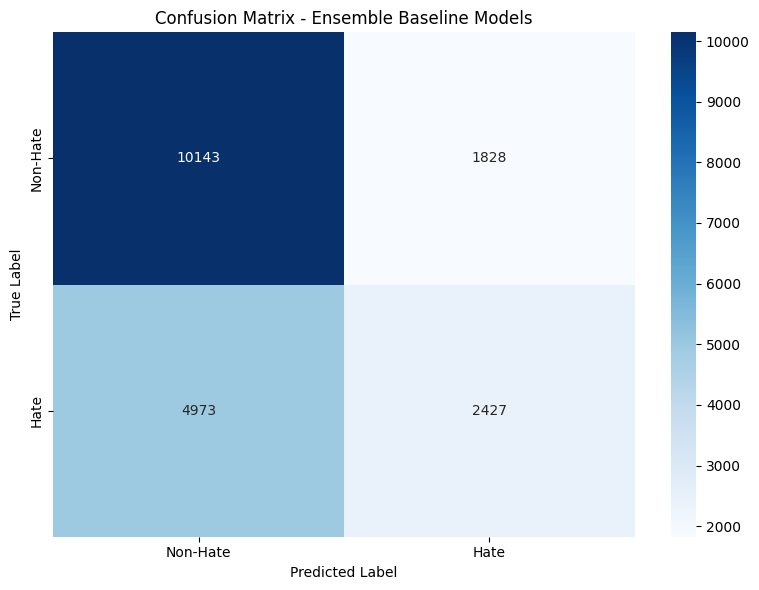

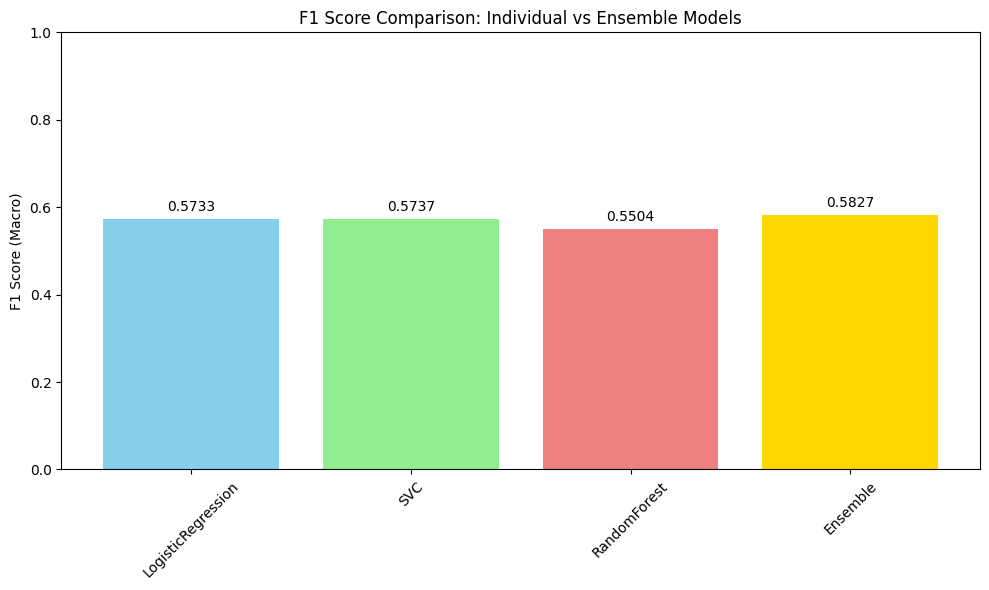


🏆 Best Model: Ensemble (F1: 0.5827)
   Improvement over best individual (SVC): 0.0090
✅ Ensemble baseline training completed!
🏆 Best baseline F1 score: 0.5827


In [ ]:
# Import training modules
from baseline_ensemble import train_ensemble_baseline_models
from transformer_training_optimized import train_multilingual_transformer_optimized
from model_export import save_baseline_model, save_huggingface_model, save_torchscript_model, save_onnx_model


# Run ensemble baseline training
print("🚀 Starting Ensemble Baseline Training...")
print("This will train Logistic Regression, Linear SVC, Random Forest, and their ensemble")
print("=" * 60)

best_baseline_model, baseline_test_results, cm_baseline, individual_results, ensemble_results = train_ensemble_baseline_models(
    X_train, X_val, X_test, y_train, y_val, y_test
)

print("✅ Ensemble baseline training completed!")
print(f"🏆 Best baseline F1 score: {baseline_test_results['f1_macro']:.4f}")


## 4. Transformer Model Training

Training multilingual transformer model for Arabic, Turkish, and English (OPTIMIZED)...
Using model: xlm-roberta-base
Training for Arabic, Turkish, and English languages (OPTIMIZED)...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded on device: cuda
Creating balanced multilingual training dataset...
Original class distribution: {np.int64(0): np.int64(95780), np.int64(1): np.int64(59205)}
Balanced class distribution: [95780 78365]
Train dataset size: 174145
Validation dataset size: 19352
Test dataset size: 19371
Starting optimized multilingual training...
Class distribution in balanced training set: [95780 78365]


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: salam-th-d (salam-th-d-gazi-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.562700,0.567774,0.694243,0.677459,0.679924,0.678526
2,0.577000,0.546159,0.709694,0.693543,0.696118,0.694675
3,0.544300,0.547140,0.709797,0.694698,0.699222,0.696436
4,0.532400,0.551141,0.713725,0.697810,0.700567,0.699016
5,0.502300,0.564252,0.719719,0.703873,0.706191,0.704919
6,0.504700,0.563369,0.721114,0.705095,0.706700,0.705845
7,0.490200,0.574430,0.720236,0.704275,0.706196,0.705159
8,0.478100,0.581019,0.720597,0.704227,0.704655,0.704438


Training completed successfully!

Testing model with multilingual examples...
Text: This is a normal message... -> 1 (0=non-hate, 1=hate), probs: [[0.41569915 0.5843008 ]]
Text: هذا رسالة عادية... -> 1 (0=non-hate, 1=hate), probs: [[0.15405756 0.84594244]]
Text: Bu normal bir mesaj... -> 1 (0=non-hate, 1=hate), probs: [[0.3683631 0.6316369]]
Text: I hate you so much... -> 0 (0=non-hate, 1=hate), probs: [[0.7976751  0.20232497]]
Text: You are stupid and worthless... -> 0 (0=non-hate, 1=hate), probs: [[0.5464356  0.45356438]]
Text: I love this beautiful day... -> 0 (0=non-hate, 1=hate), probs: [[0.8596048  0.14039516]]

Evaluating on test set...



Test Set Results:
eval_loss: 0.5551
eval_accuracy: 0.7233
eval_precision: 0.7073
eval_recall: 0.7086
eval_f1: 0.7079
eval_runtime: 17.4667
eval_samples_per_second: 1109.0230
eval_steps_per_second: 69.3320
epoch: 8.0000

Detailed Test Results:
Accuracy: 0.7233
Precision (macro): 0.7073
Precision (weighted): 0.7242
Recall (macro): 0.7086
Recall (weighted): 0.7233
F1 (macro): 0.7079
F1 (weighted): 0.7237


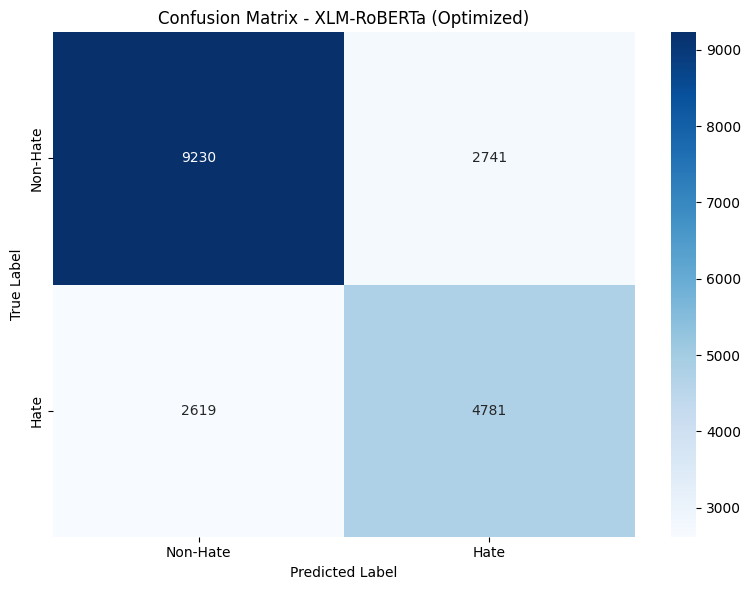

In [ ]:
# Train multilingual transformer model (OPTIMIZED VERSION)
print("Training multilingual transformer model for Arabic, Turkish, and English (OPTIMIZED)...")
model, tokenizer, transformer_test_results, cm_transformer = train_multilingual_transformer_optimized(
    X_train, X_val, X_test, y_train, y_val, y_test,
    model_name="xlm-roberta-base",
    max_length=128,
    batch_size=16,  # Larger batch size for GPU
    learning_rate=1e-5,  # Lower learning rate for better convergence
    num_epochs=8  # More epochs for better learning
)


## 5. Model Export and Saving


In [ ]:
# Reload the fixed model export module
import importlib
import model_export
importlib.reload(model_export)
from model_export import save_baseline_model, save_huggingface_model, save_torchscript_model, save_onnx_model

print("✅ Model export module reloaded with device handling fixes")


✅ Model export module reloaded with device handling fixes


In [ ]:
# Save all models
print("Saving models...")

# Save baseline model
# save_baseline_model(best_baseline_model, "models/baseline/baseline_model.pkl")

# Save HuggingFace model
save_huggingface_model(model, tokenizer, "models/transformer/hf_model")

# Save TorchScript model
save_torchscript_model(model, tokenizer, "models/transformer/torchscript/model.pt", max_length=128)

# Save ONNX model
save_onnx_model(model, "models/transformer/onnx/model.onnx", max_length=128)


Saving models...
HuggingFace model saved: models/transformer/hf_model/
Files saved:
  - special_tokens_map.json
  - tokenizer_config.json
  - config.json
  - model.safetensors
  - sentencepiece.bpe.model
  - tokenizer.json


`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


TorchScript model saved: models/transformer/torchscript/model.pt
ONNX model saved: models/transformer/onnx/model.onnx
ONNX model verification: PASSED


In [ ]:
# Download exported transformer models to your device
print("🚀 Preparing transformer models for download...")

import os
import zipfile
from google.colab import files
import shutil

def create_transformer_models_zip():
    """Create a ZIP file with only exported transformer models for download"""

    # Create models directory structure
    models_dir = "transformer_models"
    os.makedirs(models_dir, exist_ok=True)

    # Copy transformer HuggingFace model
    if os.path.exists("models/transformer/hf_model"):
        shutil.copytree("models/transformer/hf_model", f"{models_dir}/hf_model", dirs_exist_ok=True)
        print("✅ HuggingFace model copied")
    else:
        print("⚠️  HuggingFace model not found")

    # Copy ONNX model
    if os.path.exists("models/transformer/onnx/model.onnx"):
        os.makedirs(f"{models_dir}/onnx", exist_ok=True)
        shutil.copy2("models/transformer/onnx/model.onnx", f"{models_dir}/onnx/model.onnx")
        print("✅ ONNX model copied")
    else:
        print("⚠️  ONNX model not found")

    # Copy TorchScript model
    if os.path.exists("models/transformer/torchscript/model.pt"):
        os.makedirs(f"{models_dir}/torchscript", exist_ok=True)
        shutil.copy2("models/transformer/torchscript/model.pt", f"{models_dir}/torchscript/model.pt")
        print("✅ TorchScript model copied")
    else:
        print("⚠️  TorchScript model not found")

    # Create ZIP file
    zip_filename = "transformer_models.zip"
    with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(models_dir):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, models_dir)
                zipf.write(file_path, arcname)

    print(f"\n🎉 Transformer models ZIP created: {zip_filename}")
    print(f"📊 File size: {os.path.getsize(zip_filename) / (1024*1024):.1f} MB")

    return zip_filename

# Create and download transformer models
zip_filename = create_transformer_models_zip()

print(f"\n📥 Downloading {zip_filename} to your device...")
files.download(zip_filename)

print("\n✅ Download complete!")
print("\n📋 What you downloaded:")
print("   • HuggingFace transformer model (config.json, model.safetensors, etc.)")
print("   • ONNX model (model.onnx)")
print("   • TorchScript model (model.pt)")

print("\n🎯 Next steps:")
print("   1. Extract the ZIP file on your device")
print("   2. Copy models to your API directory:")
print("      - Copy hf_model/ to api/models/transformer/")
print("      - Copy onnx/model.onnx to api/models/transformer/onnx/")
print("   3. Start your API server")


🚀 Preparing transformer models for download...
✅ HuggingFace model copied
✅ ONNX model copied
✅ TorchScript model copied

🎉 Transformer models ZIP created: transformer_models.zip
📊 File size: 2379.6 MB

📥 Downloading transformer_models.zip to your device...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ Download complete!

📋 What you downloaded:
   • HuggingFace transformer model (config.json, model.safetensors, etc.)
   • ONNX model (model.onnx)
   • TorchScript model (model.pt)

🎯 Next steps:
   1. Extract the ZIP file on your device
   2. Copy models to your API directory:
      - Copy hf_model/ to api/models/transformer/
      - Copy onnx/model.onnx to api/models/transformer/onnx/
   3. Start your API server
